# A simple simulator for Stratified media under normal incidence

## Imports

In [20]:
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, c as c0

In [21]:
import sax
import meow
import meow.eme.propagate
sax_backend = meow.eme.sax._validate_sax_backend("klu")

## Layer Stack

In [22]:
ns = [2, 1.889+0.0035j, 1.802+0.0562j, 2.321+0.291j, 1.519+9j]
ds = [1, 0.15, 0.03, 0.3, 0.2]
# ns = [2]
# ds = [0.3]
# n = 1
# ns = [0.01+8j, n, 0.01+8j]
# ds = [0.003, 0.385 + 0.6, 0.003] # 
# ns = [4]
# ds = [0.35] # 
wl = 1.2
xi = jnp.cumsum(jnp.array(ds))

## Fresnel and Propagation

In [23]:
def fresnel_mirror_ij(ni=1.0, nj=1.0):
    """Model a (fresnel) interface between twoo refractive indices

    Args:
        ni: refractive index of the initial medium
        nf: refractive index of the final
    """
    r_fresnel_ij = (ni - nj) / (ni + nj)  # i->j reflection
    t_fresnel_ij = 2 * ni / (ni + nj)  # i->j transmission
    r_fresnel_ji = -r_fresnel_ij  # j -> i reflection
    t_fresnel_ji = (1 - r_fresnel_ij**2) / t_fresnel_ij  # j -> i transmission 2 * nj / (ni + nj)#
    sdict = {
        ("left", "left"): r_fresnel_ij,
        ("left", "right"): t_fresnel_ij,
        ("right", "left"): t_fresnel_ji,
        ("right", "right"): r_fresnel_ji,
    }
    return sdict


def propagation_i(ni=1.0, di=0.5, wl=wl):
    """Model the phase shift acquired as a wave propagates through medium A

    Args:
        ni: refractive index of medium (at wavelength wl)
        di: [μm] thickness of layer
        wl: [μm] wavelength
    """
    prop_i = jnp.exp(1j * 2 * jnp.pi * ni * di / wl)
    sdict = {
        ("left", "right"): prop_i,
        ("right", "left"): prop_i,
    }
    return sdict

## Layers
let's set up the sax components for the different layers

In [24]:
identity = fresnel_mirror_ij(1, 1)

In [25]:
propagations=[propagation_i(ni, di) for ni, di in zip(ns, ds)]
propagations=[identity]+propagations+[identity]
propagations = {f"p_{i}": sax.sdense(p) for i, p in enumerate(propagations)}

In [26]:
padded_ns = [1]+ns+[1]
interfaces=[fresnel_mirror_ij(ni, nj) for ni, nj in zip(padded_ns, padded_ns[1:])]
#interfaces=[identity]+interfaces+[identity]
interfaces = [sax.sdense(i) for i in interfaces]
interfaces = {f"i_{i}_{i+1}": (s.T, p) for i, (s, p) in enumerate(interfaces)}

In [27]:
interfaces

{'i_0_1': (Array([[-0.33333333+0.j,  1.33333333+0.j],
         [ 0.66666667+0.j,  0.33333333+0.j]], dtype=complex128),
  {'left': 0, 'right': 1}),
 'i_1_2': (Array([[ 0.02854121-0.00092566j,  0.97145879+0.00092566j],
         [ 1.02854121-0.00092566j, -0.02854121+0.00092566j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 'i_2_3': (Array([[ 0.0233338-0.01465539j,  0.9766662+0.01465539j],
         [ 1.0233338-0.01465539j, -0.0233338+0.01465539j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 'i_3_4': (Array([[-0.12975476-0.04602211j,  1.12975476+0.04602211j],
         [ 0.87024524-0.04602211j,  0.12975476+0.04602211j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 'i_4_5': (Array([[-0.77012925-0.40461697j,  1.77012925+0.40461697j],
         [ 0.22987075-0.40461697j,  0.77012925+0.40461697j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 'i_5_6': (Array([[ 0.94232092+0.20607849j,  0.05767908-0.20607849j],
         [ 1.94232092+0.20607849j, -0.94232092-0.20

## Propagate Interface Pairs 
Combine successive propagation sections and interfaces into Propagate Interface Pairs (pi_pairs).

In [28]:
pairs = meow.eme.propagate.pi_pairs(propagations, interfaces, sax_backend)

## Accumulate
Split the whole device into left and right sections with the split moving from left to right

In [29]:
l2rs = meow.eme.propagate.l2r_matrices(pairs, identity, sax_backend)
r2ls = meow.eme.propagate.r2l_matrices(pairs, sax_backend)

## Excite from the left

In [30]:
ex_l = jnp.array([1])
ex_r = jnp.array([0])

## Calculate Amplitudes

### Conventions
it seems like sax and meow use different conventions here:
we have to transpose 

In [31]:
# l2rs = [sax.sdense(l2r) for l2r in l2rs]
# r2ls = [sax.sdense(r2l) for r2l in r2ls]

# l2rs = [(l2r.T, p) for l2r, p in l2rs]
# r2ls = [(r2l.T, p) for r2l, p in r2ls]

In [32]:
forwards, backwards = meow.eme.propagate.propagate(l2rs, r2ls, ex_l, ex_r)

In [33]:
jnp.abs(jnp.array(forwards))

Array([[1.00000000e+00],
       [5.88804481e-01],
       [6.05495781e-01],
       [6.20899439e-01],
       [5.42496072e-01],
       [1.59832247e-01],
       [2.51934188e-05]], dtype=float64)

In [34]:
jnp.abs(jnp.array(backwards))

Array([[6.63226596e-01],
       [2.58119111e-01],
       [2.65893496e-01],
       [2.61536483e-01],
       [1.89172344e-01],
       [1.00403715e-09],
       [0.00000000e+00]], dtype=float64)

In [35]:
def fields(padded_ns, xi, forwards, backwards, x):
    """Calculates the fields within a stack at given positions x
    Attention xi > 0
    """
    xi = onp.concatenate([[-onp.inf, 0], xi, [onp.inf]])
    E_tot = onp.zeros((len(x),), dtype=complex)
    Abs_tot = onp.zeros((len(x),), dtype=complex)
    for n, forward, backward, x_min, x_max in zip(padded_ns, forwards, backwards, xi, xi[1:]):
        has_contribution = onp.any(onp.logical_and(x > x_min, x < x_max))
        if not has_contribution:
            continue
        print(f"{n}: {x_min} - {x_max}: -> {forward[0]}; <- {backward[0]}")
        i_min = onp.argmax(x >= x_min)
        i_max = onp.argmax(x > x_max)
        
        if i_max == 0:
            x_ = x[i_min:]
        else:
            x_ = x[i_min:i_max]

        if onp.isinf(x_min):
            x_local = x_
        else:
            x_local = x_ - x_min
        E_local = forward*onp.exp(2j * onp.pi * n / wl * x_local)
        E_local += backward*onp.exp(-2j * onp.pi * n / wl * x_local)

        if i_max == 0:
            E_tot[i_min:] = E_local
        else:
            E_tot[i_min:i_max] = E_local

        eps = n**2 * epsilon_0
        omega = 2 * onp.pi * c0/wl
        Abs_local = 0.5* omega * eps.imag * onp.abs(E_local)**2
        if i_max == 0:
            Abs_tot[i_min:] = Abs_local
        else:
            Abs_tot[i_min:i_max] = Abs_local
            
    return E_tot, Abs_tot

In [39]:
x = jnp.linspace(-0.4, 2, 400)
field, absorption = fields(padded_ns, xi, forwards, backwards, x)

1: -inf - 0.0: -> (1+0j); <- (-0.6488030082492338-0.13756516317386808j)
2: 0.0 - 1.0: -> (0.5877992479376914-0.03439129079346702j); <- (-0.23660225618692532-0.10317387238040107j)
(1.889+0.0035j): 1.0 - 1.15: -> (-0.3396254178307034-0.5012780826277962j); <- (0.2235943849474816-0.14389198127528927j)
(1.802+0.0562j): 1.15 - 1.18: -> (0.48031098913385123-0.39346850910805625j); <- (-0.13601547770628236-0.22338559043807j)
(2.321+0.291j): 1.18 - 1.48: -> (0.47529476330010356-0.2615279639914644j); <- (-0.10392780639383825-0.15806703230983132j)
(1.519+9j): 1.48 - 1.68: -> (-0.07911813215615915+0.1388764498403872j); <- (7.010614779830767e-10-7.187512799263496e-10j)
1: 1.68 - inf: -> (-2.015560351658355e-05-1.5114893174321723e-05j); <- 0j


Text(0, 0.5, '$|E(x)|$')

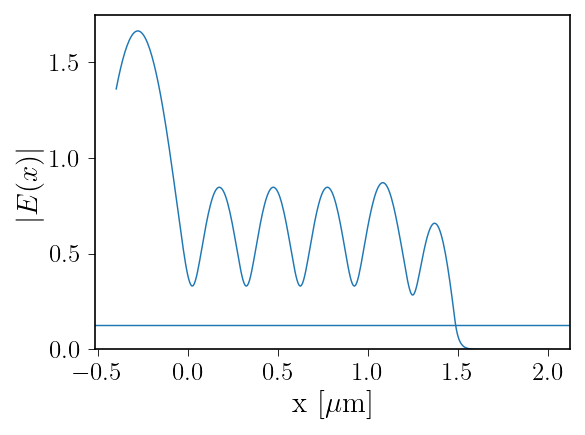

In [40]:
plt.plot(x, jnp.abs(field))
plt.axhline(0.13)
#plt.axhline(1, color="k", linestyle="--")
plt.ylim((0, None))
plt.xlabel("x [$\mu$m]")
plt.ylabel("$|E(x)|$")

/scratch/local/jdf/conda/envs/meow/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/scratch/local/jdf/conda/envs/meow/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Absorption')

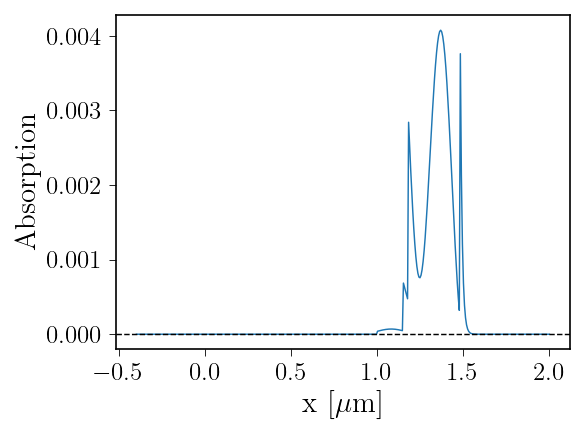

In [41]:
plt.plot(x, absorption)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("x [$\mu$m]")
plt.ylabel("Absorption")

